In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 515 (delta 139), reused 127 (delta 123), pack-reused 353
Receiving objects: 100% (515/515), 28.61 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
# hide
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.16.1


# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://github.com/Alerza/nlp-with-transformers_notebooks/blob/main/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://github.com/Alerza/nlp-with-transformers_notebooks/blob/main/images/chapter05_meena.png?raw=1" id="meena"/>

## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/Alerza/nlp-with-transformers_notebooks/blob/main/images/chapter05_text-generation.png?raw=1" id="text-generation"/> 

## Greedy Search Decoding

In [3]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

In [25]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
#number of top choice for next word
choices_per_step = 5

print('input_ids = '+ str(input_ids))

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        print('iteration["Input"] = '+iteration["Input"])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        print('output.logits.shape=(batch_size,sequence? ,size of the vocabulary) '+str(output.logits.shape))
        next_token_logits = output.logits[0, -1, :]
        print('next_token_logits.shape = '+str(next_token_logits.shape))
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        print('next_token_probs.shape = '+str(next_token_probs.shape))
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        print('sorted_ids[0:10] = '+str(sorted_ids[:10]))
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

input_ids = tensor([[41762,   364,   389,   262]], device='cuda:0')
iteration["Input"] = Transformers are the
output.logits.shape=(batch_size,sequence? ,size of the vocabulary)
torch.Size([1, 4, 50257])
next_token_logits.shape = torch.Size([50257])
next_token_probs.shape = torch.Size([50257])
sorted_ids[0:10] = tensor([  749,   691,  1266, 39185,  8713,  2818,   717,
4094,   938,  6000],
       device='cuda:0')
iteration["Input"] = Transformers are the most
output.logits.shape=(batch_size,sequence? ,size of the vocabulary)
torch.Size([1, 5, 50257])
next_token_logits.shape = torch.Size([50257])
next_token_probs.shape = torch.Size([50257])
sorted_ids[0:10] = tensor([ 2968,  3665,  2219,  5863,  4388,  4923,  1593,
14133,  1884,   880],
       device='cuda:0')
iteration["Input"] = Transformers are the most popular
output.logits.shape=(batch_size,sequence? ,size of the vocabulary)
torch.Size([1, 6, 50257])
next_token_logits.shape = torch.Size([50257])
next_token_probs.shape = torch.Size([5

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Transformers are the most popular toy line in the world,


In [26]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


## Beam Search Decoding

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://github.com/Alerza/nlp-with-transformers_notebooks/blob/main/images/chapter05_beam-search.png?raw=1" id="beam-search"/> 

In [ ]:
0.5 ** 1024

5.562684646268003e-309

In [27]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

محاسبه احتمال لاگ برای جملات ساخته شده در روشهای مختلف

Since  Transformers models return the unnormalized logits for the next token given the input tokens, we first need to normalize the logits to create a probability distribution over the whole vocabulary for each token in the sequence. We then need to select only the token probabilities that were present in the sequence

In [48]:
import torch.nn.functional as F

#claculate softmax and then log of logits and select item base of label
#ابتدا لاگ سافت مکس را برای لاجیت محاسبه میکند و کل احتمال لاگ را برای کل وکب به دست میآورد سپس مقدار آن را برای کلمه ای که در متن وجود دارد برمیدارد
def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

to get the total log probability of a sequence we just need to sum the log probabilities for each token

In [49]:
#محاسبه برای کل جمله
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

calculate the sequence log probability of the greedy decoder on the OpenAI prompt

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -87.43


To activate beam search with the generate() function we just need to specify the number of beams with the num_beams parameter. 

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery of the unicorns was made by a team of scientists from the
University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains. Even more surprising to the researchers was the fact
that the unicorns spoke perfect English

log-prob: -55.23


 we get a better log probability (higher is better) with beam search than we did with simple greedy decoding.

‏می‌توانیم ببینیم که با جستجوی پرتو، احتمال-لاگ بهتری (بیشتر بهتر) نسبت به رمزگشایی ساده حریصانه به دست می‌آوریم. با این حال، می‌توانیم ببینیم که جستجوی پرتو نیز از متن تکراری رنج می‌برد. یکی از راه‌های رفع این مشکل، اعمال یک جریمه n-گرمی با پارامتر no_repeat_ngram_size است که n-گرم دیده شده را ردیابی می‌کند و اگر یک n-گرم قبلاً دیده شده را تولید کند، احتمال توکن بعدی را صفر می‌کند:

In [51]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=5)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery of the unicorns was made by a team of scientists from the
University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they came
across the herd of unicorns.


The researchers were surprised to find that the unicorns were able to
communicate with each other in English.


According to the researchers, the

log-prob: -77.71


## Sampling Methods

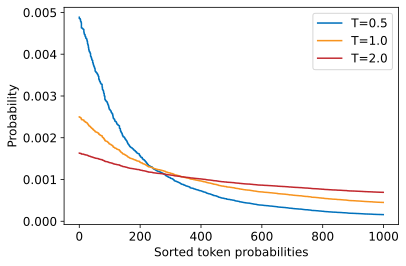

In [52]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [53]:
# hide
torch.manual_seed(42);

In [54]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Banglington station line protagonist Bree Miller woke nostalgiate Rider
Faithrometta Bluial Mju Agreement generously brings Kashun Dracozin Auctuz
Doraelque Pumpkin meremavern stall class inequariansiamond disse * Runew
Endurance whilst spear secured majorityb zo coachinginventoryatelletonwarming
instinctivelypres Wrestling chargesThingsCooldown Guillard Ty physicianness
Kimvillecurrently exhaustionSince at aff da temporacia MD RIPAbout iter


In [ ]:
# hide
torch.manual_seed(42);

In [55]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The unicorn herd was discovered in the Andes Mountains.

The researchers, from the University of California, Los Angeles, spent two years
studying the valley, which is located in the Andes Mountains in Peru. The valley
was once a lush, green landscape, but now it is a desolate, barren landscape.

The valley is the largest in the Andes, but it is also the most


## Top-k and Nucleus Sampling

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [ ]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

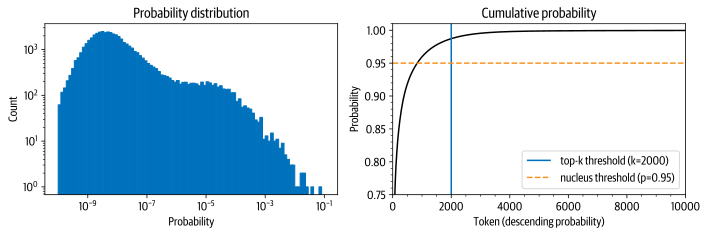

In [ ]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the
border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire
Naturelle)

The researchers came across about 50 of the animals in the valley. They had
lived in such a remote and isolated area at that location for nearly a thousand
years that


In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came to the conclusion that
the herd are descendants of a prehistoric herd that lived in Argentina about
50,000 years ago.


According to the scientific analysis, the first humans who migrated to South
America migrated into the Andes Mountains from South Africa and Australia, after
the last ice age had ended.


Since their migration, the animals have been adapting to


## Which Decoding Method Is Best?

## Conclusion